In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees
from src.evals.eval_trees import EvalCntrees
from decoding_utils import fit_and_evaluate_classification, fit_and_evaluate_regression

# Arguments 

In [2]:
corr = 0.25

# Load Model

In [3]:
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "tree_maze_bigger_models")

epoch=24-val_loss=0.000703.ckpt


In [4]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": dropout,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
}

In [5]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

# Load Dataset and Create Environment

In [6]:
def load_eval_trajs(eval_dset_path):
    is_h5_file = eval_dset_path.endswith('.h5')
    if is_h5_file:
        eval_trajs = h5py.File(eval_dset_path, 'r')
    else:  # Pickle file
        with open(eval_dset_path, 'rb') as f:
            eval_trajs = pickle.load(f)
    n_eval_envs = len(eval_trajs)
    return eval_trajs, n_eval_envs

eval_trajs_1, n_eval_envs_1 = load_eval_trajs(eval_dset_path)
eval_trajs_2, n_eval_envs_2 = load_eval_trajs(eval_dset_path.replace('eval', 'train'))
eval_trajs_3, n_eval_envs_3 = load_eval_trajs(eval_dset_path.replace('eval', 'test'))
eval_trajs = eval_trajs_1 + eval_trajs_2 + eval_trajs_3
n_eval_envs = n_eval_envs_1 + n_eval_envs_2 + n_eval_envs_3

In [7]:
def run_model(traj, model, state_features, seq_length, zero_reward=False):
    hidden_states = [[] for _ in range(model.n_layer)]
    outputs = []
    
    for state_feature in state_features: 
        batch = {
            'context_states': convert_to_tensor([np.array(traj['context_states'])]),
            'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
            'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
            'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
            'query_states': convert_to_tensor([np.array(state_feature)]),
            }
        batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
        for k in batch.keys():
            if 'context' in k:
                batch[k] = batch[k][:,:seq_length]
            batch[k] = batch[k].to(model.device)
        model.save_activations = True
        if zero_reward:
            batch['context_rewards'] *= 0
        with torch.no_grad():
            out = model(batch)
            outputs.append(torch.argmax(out).item())
        _hidden_states = model.activations['hidden_states'][1:] # Tuple over layers
        for i_layer in range(model.n_layer):
            hidden_states[i_layer].append(_hidden_states[i_layer])
    return hidden_states, outputs

# Across context decoding
(within-context is not that good)

In [8]:
def get_subtree_location(layer, pos, subtree):
    midpt = 2**(layer-1)
    quarter_pt = midpt//2
    eighth_pt = quarter_pt//2
    if layer == 0:
        return 0
    if subtree == 'half':
        return 1 if pos < midpt else 2
    elif subtree == 'quarter':
        if layer == 1:
            return 0
        bins = np.arange(0, 2**layer, quarter_pt)
        return np.digitize([pos], bins)[0]
    elif subtree == 'eighth':
        if (layer == 1) or (layer == 2):
            return 0
        bins = np.arange(0, 2**layer, eighth_pt)
        return np.digitize([pos], bins)[0]

    

In [9]:
train_envs = np.arange(1, int(n_eval_envs*0.9))
test_envs = np.arange(int(n_eval_envs*0.9), n_eval_envs)

def make_train_test_matrices():
    X = [[] for _ in range(model.n_layer)]
    Ys_dict = {
        "dist_from_goal": [],
        "layer": [],
        "node_identity": [],
        "maze_half": [],
        "maze_quarter": [],
        "maze_eighth": [],
        'is_goal': [],
        'same_half_as_goal': [],
        'same_quarter_as_goal': [],
        'opt_action': [],
        'state_feature': [],
        'next_state_feature': [],
        'action': [],
    }
    for i_eval in range(n_eval_envs):
        onehot_env = np.zeros(n_eval_envs)
        onehot_env[i_eval] = 1
        traj = eval_trajs[i_eval]
        seen_states = np.vstack((traj['context_states'][:1], traj['context_next_states']))
        seen_states = np.unique(seen_states, axis=0) 

        first_reward = np.argwhere(np.array(traj['context_rewards'])>0)
        if (first_reward.size == 0) or (first_reward[0] > 800):
            continue

        env_config = {
            'max_layers': 7,
            'horizon': 1600,
            'branching_prob': 1.0,
            'node_encoding_corr': corr,
            'state_dim': state_dim,
            'initialization_seed': np.array(traj['initialization_seed']).item()
        }
        env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)
        opt_action_map, dist_from_goal = env.make_opt_action_dict()

        seq_length = 1000
        hidden_states, outputs = run_model(traj, model, seen_states, seq_length)
        goal_node = env.node_map[tuple(env.goal.tolist())]
        goal_layer = goal_node.layer
        goal_pos = goal_node.pos
        for state_idx, state_feature in enumerate(seen_states):
            state_feature_tuple = tuple(state_feature.tolist())
            d = dist_from_goal[state_feature_tuple]
            layer = env.node_map[state_feature_tuple].layer
            pos = env.node_map[state_feature_tuple].pos
            node_identity = 2**layer + pos
            maze_half = get_subtree_location(layer, pos, 'half')
            maze_quarter = get_subtree_location(layer, pos, 'quarter')
            maze_eighth = get_subtree_location(layer, pos, 'eighth')
            action = outputs[state_idx]
            opt_action = np.zeros(4)
            opt_action[opt_action_map[state_feature_tuple]] = 1
            next_state_feature, _ = env.transit(state_feature, action)
            
            Ys_dict["dist_from_goal"].append(d)
            Ys_dict["layer"].append(layer)
            Ys_dict["node_identity"].append(node_identity)
            Ys_dict["maze_half"].append(maze_half)
            Ys_dict["maze_quarter"].append(maze_quarter)
            Ys_dict["maze_eighth"].append(maze_eighth)
            Ys_dict["is_goal"].append(state_feature_tuple == tuple(env.goal.tolist()))
            Ys_dict["same_half_as_goal"].append(maze_half == get_subtree_location(goal_layer, goal_pos, 'half'))
            Ys_dict["same_quarter_as_goal"].append(maze_quarter == get_subtree_location(goal_layer, goal_pos, 'quarter'))
            Ys_dict["opt_action"].append(opt_action_map[state_feature_tuple])
            Ys_dict["state_feature"].append(state_feature)
            Ys_dict["next_state_feature"].append(next_state_feature)
            Ys_dict["action"].append(action)
            for layer in range(model.n_layer):
                hidden_state = hidden_states[layer][state_idx][0, -1].to('cpu').numpy()
                hidden_state = np.concatenate([hidden_state, onehot_env])
                X[layer].append(hidden_state)
        torch.cuda.empty_cache()
    test_size = 0.1
    test_start_idx = int(len(X[0])*(1-test_size))
    all_indices = np.arange(len(X[0]))
    np.random.shuffle(all_indices)
    train_indices = all_indices[:test_start_idx]
    test_indices = all_indices[test_start_idx:]

    X_train = [[] for _ in range(model.n_layer)]
    X_test = [[] for _ in range(model.n_layer)]
    Ys_dict_train_test = {key: {'Y_train': [], 'Y_test': []} for key in Ys_dict}
    # Use same indices for all layers to keep corresponding samples together
    for layer, layer_data in enumerate(X):
        X_train[layer] = [layer_data[i] for i in train_indices]
        X_test[layer] = [layer_data[i] for i in test_indices]
    for key in Ys_dict:
        Ys_dict_train_test[key]['Y_train'] = [Ys_dict[key][i] for i in train_indices]
        Ys_dict_train_test[key]['Y_test'] = [Ys_dict[key][i] for i in test_indices]
    return X_train, X_test, Ys_dict_train_test

# Run decoding

In [10]:
X_train, X_test, Ys_dict = make_train_test_matrices()

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Layer 0:
Best alpha: 21.544
Train R2: 0.944
Test R2: 0.951



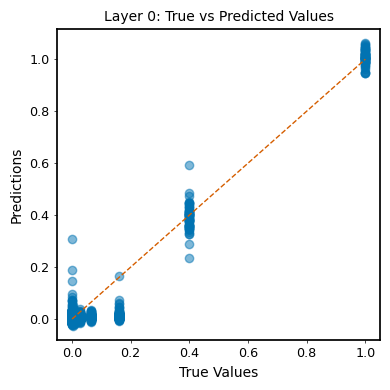

Layer 1:
Best alpha: 21.544
Train R2: 0.948
Test R2: 0.953



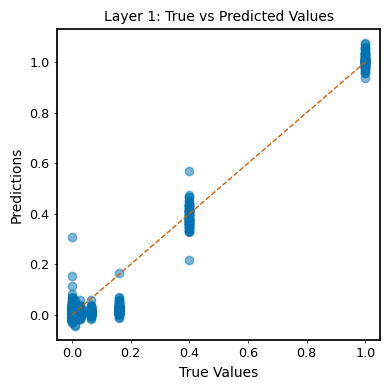

Layer 2:
Best alpha: 21.544
Train R2: 0.960
Test R2: 0.964



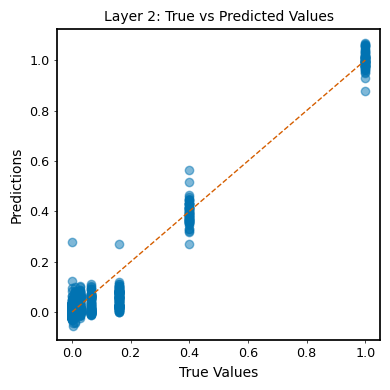

Layer 0:
Best alpha: 59.948
Train R2: 0.882
Test R2: 0.893



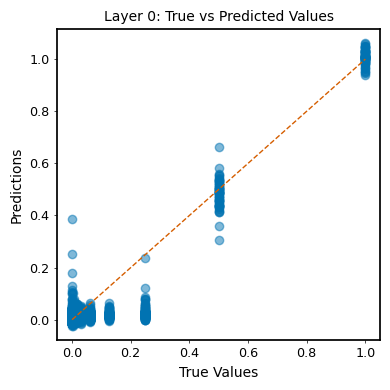

Layer 1:
Best alpha: 21.544
Train R2: 0.891
Test R2: 0.900



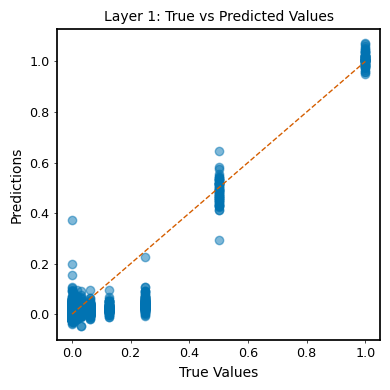

Layer 2:
Best alpha: 21.544
Train R2: 0.922
Test R2: 0.928



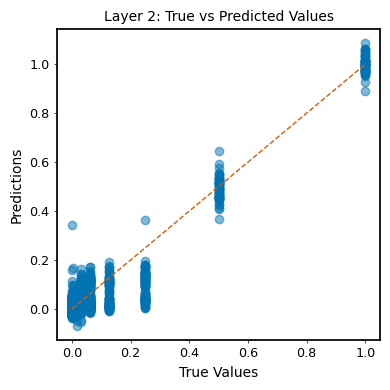

Layer 0:
Best alpha: 59.948
Train R2: 0.780
Test R2: 0.796



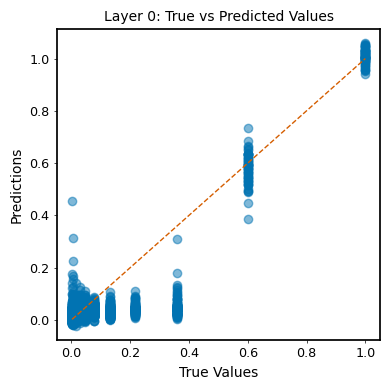

Layer 1:
Best alpha: 59.948
Train R2: 0.794
Test R2: 0.810



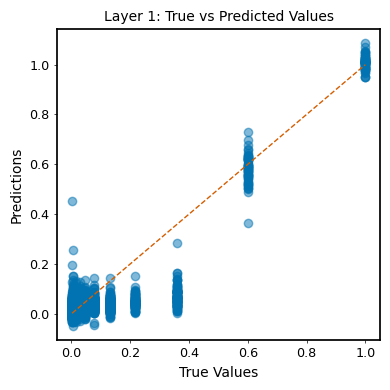

Layer 2:
Best alpha: 21.544
Train R2: 0.859
Test R2: 0.870



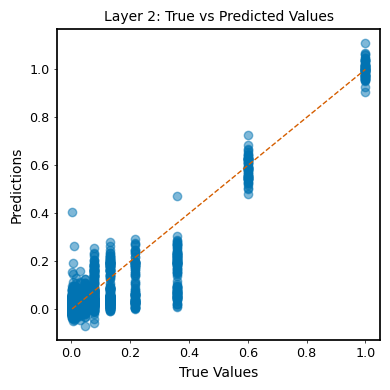

Layer 0:
Best alpha: 166.810
Train R2: 0.640
Test R2: 0.663



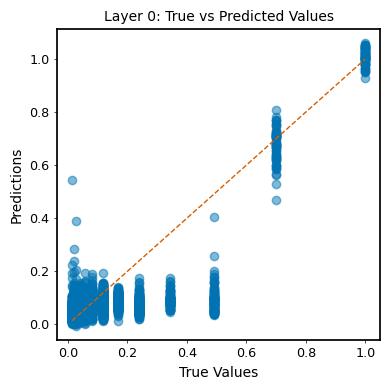

Layer 1:
Best alpha: 59.948
Train R2: 0.665
Test R2: 0.686



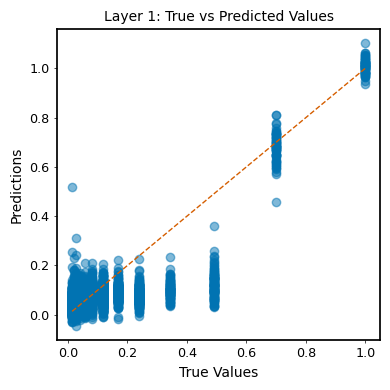

Layer 2:
Best alpha: 59.948
Train R2: 0.772
Test R2: 0.789



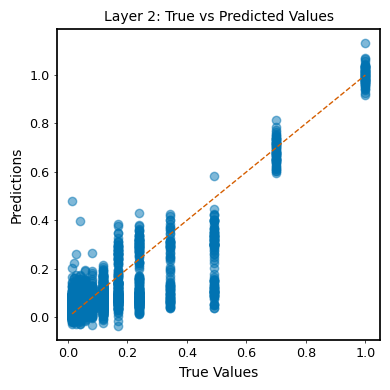

Layer 0:
Best alpha: 166.810
Train R2: 0.497
Test R2: 0.516



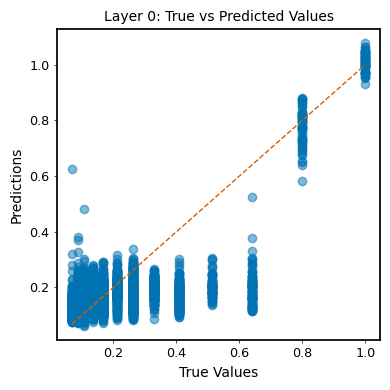

Layer 1:
Best alpha: 59.948
Train R2: 0.530
Test R2: 0.550



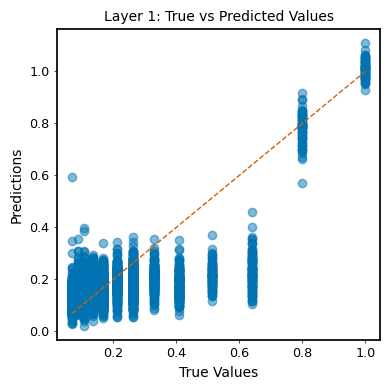

Layer 2:
Best alpha: 59.948
Train R2: 0.670
Test R2: 0.691



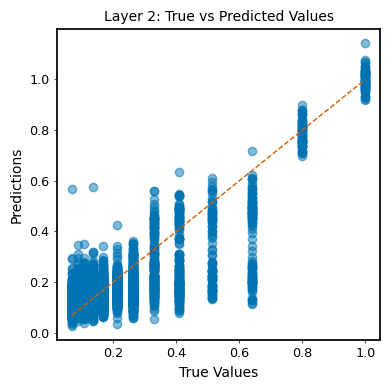

Layer 0:
Best alpha: 464.159
Train R2: 0.383
Test R2: 0.395



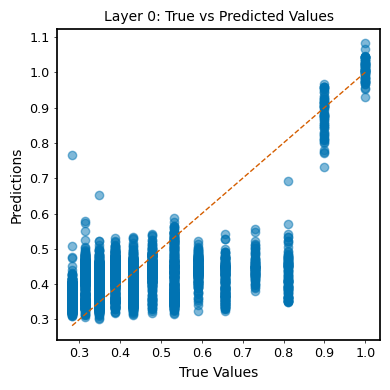

Layer 1:
Best alpha: 59.948
Train R2: 0.423
Test R2: 0.436



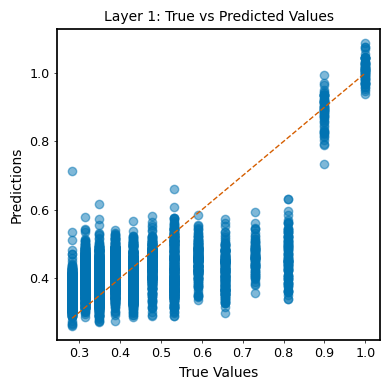

Layer 2:
Best alpha: 59.948
Train R2: 0.573
Test R2: 0.591



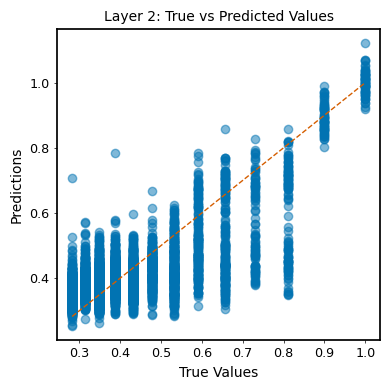

In [11]:
results = {
    'gamma': [],
    'test_score': [],
    'test_y': [],
    'test_pred': [],
}
for gamma in np.arange(0.4, 1.0, 0.1):
    _Ys_dict_train = [gamma**d for d in Ys_dict["dist_from_goal"]["Y_train"]]
    _Ys_dict_test = [gamma**d for d in Ys_dict["dist_from_goal"]["Y_test"]]
    _results = fit_and_evaluate_regression(X_train, _Ys_dict_train, X_test, _Ys_dict_test)
    results['gamma'].append(gamma)
    results['test_score'].append(_results[1])
    results['test_y'].append(_results[2])
    results['test_pred'].append(_results[3])

with open('pickles/09_query_token_decoding_q_value_dist.pkl', 'wb') as f:
    pickle.dump(results, f)

In [12]:
_results[1]

[array([0.05385819, 0.13124272, 0.11672824, ..., 0.03552803, 0.00615508,
        0.09940709]),
 array([0.02448267, 0.12141216, 0.12022954, ..., 0.0346532 , 0.07378411,
        0.0995624 ]),
 array([0.00734733, 0.09136951, 0.13455454, ..., 0.06535391, 0.04096732,
        0.0508415 ])]